In [10]:
import torch
from torch import nn, optim
from torch import hub
import torch.nn.functional as F
import numpy as np

import torchvision
import torchvision.models as models
yolov5s = torch.hub.load('ultralytics/yolov5', 'yolov5s')
from models.common import DetectMultiBackend

import cv2
from matplotlib import pyplot as plt

In [191]:
support_labels = torch.tensor([0,0,1,1,2,2], dtype=torch.float32)
support = torch.tensor([[1,0,3],[2,3,1],[5,5,5],[2,4,3],[1,1,3],[3,1,4]], dtype=torch.float32)
query = 5*torch.rand(5,1,3)
print(support_labels)
print(support)
print(query)

tensor([0., 0., 1., 1., 2., 2.])
tensor([[1., 0., 3.],
        [2., 3., 1.],
        [5., 5., 5.],
        [2., 4., 3.],
        [1., 1., 3.],
        [3., 1., 4.]])
tensor([[[3.2325, 0.7804, 4.2180]],

        [[1.9897, 4.4679, 2.1198]],

        [[2.4414, 3.5754, 2.1949]],

        [[2.8187, 2.2285, 4.1445]],

        [[4.2768, 4.2557, 0.8889]]])


In [176]:
a = torch.tensor([[1.,0.,0.]])
b = torch.tensor([[2.,0.,0.]])
dist = torch.cdist(a,b)
print(dist)

tensor([[1.]])


In [153]:
z_proto = torch.cat([support[torch.nonzero(support_labels == label)].mean(0) for label in range(3)])
print(z_proto)

tensor([[1.5000, 1.5000, 2.0000],
        [3.5000, 4.5000, 4.0000],
        [2.0000, 1.0000, 3.5000]])


In [192]:
dists = torch.cdist(query, z_proto)
print(dists)

tensor([[[2.9050, 3.7356, 1.4432]],

        [[3.0104, 2.4119, 3.7325]],

        [[2.2872, 2.2878, 2.9207]],

        [[2.6208, 2.3759, 1.6109]],

        [[4.0668, 3.2159, 4.7541]]])


In [193]:
scores = torch.min(dists,2)
print(scores)

torch.return_types.min(
values=tensor([[1.4432],
        [2.4119],
        [2.2872],
        [1.6109],
        [3.2159]]),
indices=tensor([[2],
        [1],
        [0],
        [2],
        [1]]))


In [10]:
m = nn.Flatten()
output = m(input)
print(output)

tensor([[-0.1800, -0.3051, -0.9335,  0.7520],
        [ 0.4261, -0.8647,  0.2461,  0.4475],
        [-0.7298, -0.3049, -0.2678, -0.0351],
        [-2.0060,  0.2697, -0.6487,  0.6943],
        [ 0.2362, -0.2848,  0.4878, -0.9312]])


In [23]:
#output2 = output.view(torch.Size(output), -1)
print(output2.view(1,-1))

tensor([[-0.1800, -0.3051, -0.9335,  0.7520,  0.4261, -0.8647,  0.2461,  0.4475,
         -0.7298, -0.3049, -0.2678, -0.0351, -2.0060,  0.2697, -0.6487,  0.6943,
          0.2362, -0.2848,  0.4878, -0.9312]])


In [87]:
cnn = models.vgg16()
print(next(cnn.modules()))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [71]:
N_WAY=2

In [166]:
class few_shot_classifier(nn.Module):
    def __init__(self, backbone: nn.Module, num_classes):
        super(few_shot_classifier, self).__init__()
        backbone.requires_grad_()
        self.backbone = backbone
        self.fc1 = nn.Linear(in_features=1000, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=10)
        self.fc3 = nn.Linear(in_features=10, out_features=num_classes)
        
    def forward(
        self,
        image: torch.Tensor
    ) -> torch.Tensor:
          
        feature = self.backbone.forward(image)
        
        out = F.relu(self.fc1(feature))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out
        
        
model = few_shot_classifier(cnn, N_WAY)
print(model)

few_shot_classifier(
  (backbone): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=Tru

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients


DetectMultiBackend(
  (model): Model(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv3): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): Sequential(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
        

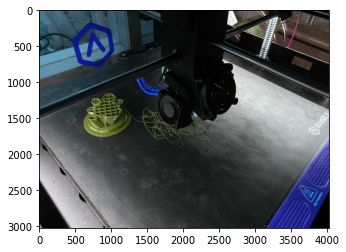

In [34]:
# Load model and image

yolo_weights_path = '/home/ubuntu/workspace/yolov5/runs/train/exp83/weights/best.pt'
yolov5s = DetectMultiBackend(yolo_weights_path, dnn=False)
print(yolov5s)
#print(yolov5s)
%matplotlib inline
img0 = cv2.imread('/home/ubuntu/workspace/datasets/real_spag/IMG_2830.JPG')
#Show the image with matplotlib
plt.imshow(img0)
plt.show()



In [24]:
# Resize image to 640x480
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)

img, _, _ = letterbox(img0, 640, stride=32, auto=True)
img = img.transpose((2,0,1))[::-1]
img = np.ascontiguousarray(img)

print(img.shape)


(3, 480, 640)


In [30]:
# Normalize Image
im = torch.from_numpy(img)
im = im.float()  # uint8 to fp16/32
im /= 255  # 0 - 255 to 0.0 - 1.0
if len(im.shape) == 3:
    im = im[None]  # expand for batch dim


tensor([[[7.17589e+00, 6.12521e+00, 8.48424e+00, 1.84410e+01, 5.05709e-05, 9.99999e-01],
         [1.23170e+01, 6.35054e+00, 1.55322e+01, 2.40081e+01, 3.81993e-05, 9.99999e-01],
         [1.75782e+01, 5.78273e+00, 2.08043e+01, 2.63793e+01, 4.47160e-05, 9.99999e-01],
         ...,
         [5.61643e+02, 4.44282e+02, 1.52337e+02, 9.20732e+01, 8.42254e-05, 9.99998e-01],
         [5.76627e+02, 4.44896e+02, 1.40173e+02, 9.65772e+01, 2.99899e-05, 9.99998e-01],
         [6.13795e+02, 4.48140e+02, 1.11629e+02, 1.10565e+02, 3.94099e-06, 9.99998e-01]]])


TypeError: Invalid shape (1, 18900, 6) for image data

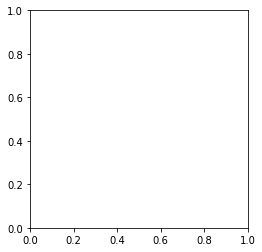

In [33]:
import time

# Inference
def non_max_suppression(prediction, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False, multi_label=False,
                        labels=(), max_det=300):
    """Runs Non-Maximum Suppression (NMS) on inference results

    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """

    nc = prediction.shape[2] - 5  # number of classes
    xc = prediction[..., 4] > conf_thres  # candidates

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

    # Settings
    min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 10.0  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    t = time.time()
    output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            l = labels[xi]
            v = torch.zeros((len(l), nc + 5), device=x.device)
            v[:, :4] = l[:, 1:5]  # box
            v[:, 4] = 1.0  # conf
            v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue
        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
        else:  # best class only
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        elif n > max_nms:  # excess boxes
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]
        if (time.time() - t) > time_limit:
            print(f'WARNING: NMS time limit {time_limit}s exceeded')
            break  # time limit exceeded

    return output


pred = yolov5s(im, augment=False, visualize=False)
pred = non_max_suppression(pred)

print(pred)

In [ ]:


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


        
        